# Objective:
In this analysis, we take on the policing in Los Angeles, specifically looking at arrest records from the LAPD. 
Do arrest locations have a statistical significant tendency to cluster in certain communities? 
To answer this question, we not only look at the location of recorded arrests in the city, 
but compare these locations with other arrests. In short, we are seeking to see where spatial 
correlations occur based on the data. Our approach is:

- import census block group boundaries for Los Angeles
- import arrest data from the LA Open Data Portal
- spatially join the two datasets
- normalize the data to create arrests per 1000
- conduct global spatial autocorrelation using Moran's I

In [13]:
#pip install sodapy

#pip install geopandas

#! pip install pandas

#pip install numpy
#pip install --force-reinstall numpy==1.26.4

#pip install contextily

# pip install numba

#pip install esda

#pip install splot --user

# pip install libpysal

In [25]:
# ! pip uninstall numpy
# ! pip install numpy
#! pip install --force-reinstall numpy==1.26.4 --user

! pip install numpy==1.26.4  pyyaml

In [27]:
# !pip uninstall pandas
! pip install pandas

^C


In [1]:
#to read and wrangle data
import pandas as pd

#Specifying numpy version for geo libraries to run
#pip install --force-reinstall numpy==1.26.4 --user

#to import data from LA Data portal
from sodapy import Socrata

#to create spatial data
import geopandas as gpd

#for basemap
import contextily as ctx

#for Spatial Statistics
import esda
from esda.moran import Moran, Moran_Local

# import splot
# from splot.esda import moral_scatterplot, plot_moral, lisa_cluster, plot_moran_simulation

import libpysal as lps

#Graphics
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
import geopandas as gpd

##### Data Exploration: Total population in Los Angeles (source: https://censusreporter.org/data/table/?table=B01003&geo_ids=16000US0644000,150|16000US0644000,140|16000US0644000&primary_geo_id=16000US0644000)

In [4]:
gdf=gpd.read_file("C:/Users/User/Desktop/GIS/total_population_GeoJSON/Total_population.geojson")

In [6]:
gdf.head()

,geoid,name,B01003001,"B01003001, Error",geometry
0,14000US06037101110,"Census Tract 1011.10, Los Angeles, CA",4014.0,473.0,"MULTIPOLYGON (((-118.30229 34.2587, -118.30091..."
1,14000US06037101122,"Census Tract 1011.22, Los Angeles, CA",4164.0,822.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033..."
2,14000US06037101220,"Census Tract 1012.20, Los Angeles, CA",3481.0,467.0,"MULTIPOLYGON (((-118.28592 34.25404, -118.2859..."
3,14000US06037101221,"Census Tract 1012.21, Los Angeles, CA",3756.0,687.0,"MULTIPOLYGON (((-118.29792 34.25597, -118.2969..."
4,14000US06037101222,"Census Tract 1012.22, Los Angeles, CA",2808.0,424.0,"MULTIPOLYGON (((-118.29434 34.25233, -118.2931..."


In [7]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3806 entries, 0 to 3805
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             3806 non-null   object  
 1   name              3806 non-null   object  
 2   B01003001         3806 non-null   float64 
 3   B01003001, Error  3806 non-null   float64 
 4   geometry          3806 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 148.8+ KB


In [44]:
# trim the data to useful columns
gdf=gdf[['geoid','B01003001','geometry']]

# rename the columns
gdf.columns= ['FIPS','TotalPop','Geometry']

In [9]:
gdf.tail()

,FIPS,TotalPop,Geometry
3801,15000US060379800281,0.0,"MULTIPOLYGON (((-118.45246 33.94315, -118.4464..."
3802,15000US060379800311,954.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
3803,15000US060379800391,0.0,"MULTIPOLYGON (((-118.36215 34.13903, -118.3612..."
3804,15000US060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
3805,16000US0644000,3881041.0,"MULTIPOLYGON (((-118.66818 34.18987, -118.6681..."


In [10]:
#census data's last row is a total that need to be taken off for the data validation purpose
gdf=gdf.drop(3805)

In [11]:
gdf.tail()

,FIPS,TotalPop,Geometry
3800,15000US060379800261,11.0,"MULTIPOLYGON (((-118.35173 34.28034, -118.3517..."
3801,15000US060379800281,0.0,"MULTIPOLYGON (((-118.45246 33.94315, -118.4464..."
3802,15000US060379800311,954.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
3803,15000US060379800391,0.0,"MULTIPOLYGON (((-118.36215 34.13903, -118.3612..."
3804,15000US060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."


In [12]:
# fixing FIPS (Federal Information Processing Standards) code. we can drop 15000US from fips as the LA county code starts from 06. the 15000US code is census code that is not required for current analysis.
gdf['FIPS'] = gdf['FIPS'].str.replace('15000US','')
gdf.tail()

,FIPS,TotalPop,Geometry
3800,060379800261,11.0,"MULTIPOLYGON (((-118.35173 34.28034, -118.3517..."
3801,060379800281,0.0,"MULTIPOLYGON (((-118.45246 33.94315, -118.4464..."
3802,060379800311,954.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
3803,060379800391,0.0,"MULTIPOLYGON (((-118.36215 34.13903, -118.3612..."
3804,060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."


In [13]:
# Sorting data by Total population
gdf.sort_values(by='TotalPop').head(20)

,FIPS,TotalPop,Geometry
3804,060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
3646,060372774001,0.0,"MULTIPOLYGON (((-118.37847 33.94652, -118.3784..."
3647,060372774002,0.0,"MULTIPOLYGON (((-118.37868 33.9518, -118.37862..."
1043,14000US06037277400,0.0,"MULTIPOLYGON (((-118.37868 33.9518, -118.37862..."
1111,14000US06037980020,0.0,"MULTIPOLYGON (((-118.34412 34.21411, -118.3440..."
1113,14000US06037980022,0.0,"MULTIPOLYGON (((-118.50266 34.30809, -118.5026..."
1114,14000US06037980023,0.0,"MULTIPOLYGON (((-118.6487 34.2312, -118.64803 ..."
1119,14000US06037980039,0.0,"MULTIPOLYGON (((-118.36215 34.13903, -118.3612..."
1120,14000US06037990200,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
3803,060379800391,0.0,"MULTIPOLYGON (((-118.36215 34.13903, -118.3612..."


#### assuming 0 population areas can be parks, airports, inndustrial area etc. Creating a subset of data with significant population.

In [16]:
# delete less than 100 population geographies
gdf = gdf[gdf['TotalPop']>100]
gdf.head()

,FIPS,TotalPop,Geometry
0,14000US06037101110,4014.0,"MULTIPOLYGON (((-118.30229 34.2587, -118.30091..."
1,14000US06037101122,4164.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033..."
2,14000US06037101220,3481.0,"MULTIPOLYGON (((-118.28592 34.25404, -118.2859..."
3,14000US06037101221,3756.0,"MULTIPOLYGON (((-118.29792 34.25597, -118.2969..."
4,14000US06037101222,2808.0,"MULTIPOLYGON (((-118.29434 34.25233, -118.2931..."


### projection for spatial analysis

In [23]:
gdf.columns= ['FIPS','TotalPop','geometry']

#geometry is key term for setting 

In [24]:
#get the layers into a web mercator projection
# reprojection to web mercator

gdf = gdf.to_crs(epsg=3857)

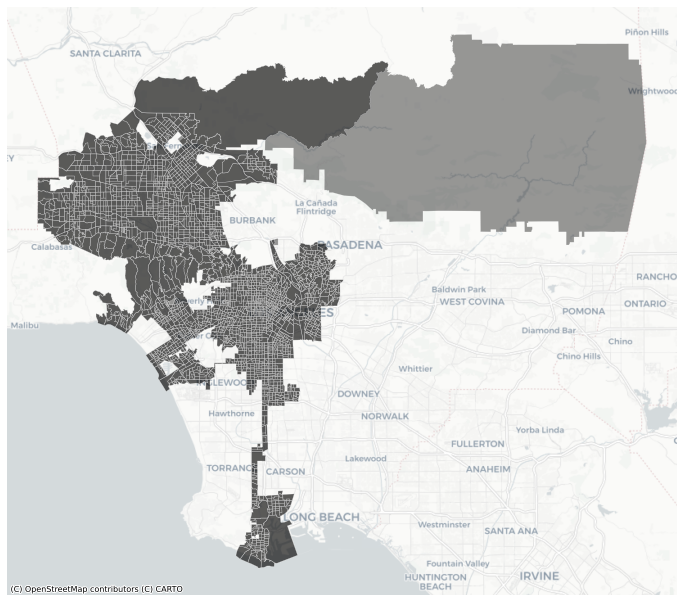

In [26]:
# Create some plots

fig, ax = plt.subplots(figsize=(12,12))

gdf.plot(ax=ax,
        color='black',
        edgecolor='white',
        lw=0.5,
        alpha=0.4)

#no axis
ax.axis('off')

#add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


In [28]:
# Adding LA arrest data via API (https://dev.socrata.com/foundry/data.lacity.org/amvf-fr72)

# connect to the data portal
client = Socrata("data.lacity.org", None)

results = client.get("amvf-fr72", 
                     limit=50000,
                     where = "arst_date between '2023-07-01T00:00:00' and '2024-01-31T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
arrests = pd.DataFrame.from_records(results)

In [31]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37982 entries, 0 to 37981
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rpt_id           37982 non-null  object
 1   report_type      37982 non-null  object
 2   arst_date        37982 non-null  object
 3   time             37980 non-null  object
 4   area             37982 non-null  object
 5   area_desc        37982 non-null  object
 6   rd               37982 non-null  object
 7   age              37982 non-null  object
 8   sex_cd           37982 non-null  object
 9   descent_cd       37982 non-null  object
 10  chrg_grp_cd      33914 non-null  object
 11  grp_description  33910 non-null  object
 12  arst_typ_cd      37982 non-null  object
 13  charge           37982 non-null  object
 14  chrg_desc        33914 non-null  object
 15  dispo_desc       34053 non-null  object
 16  location         37982 non-null  object
 17  crsst            15884 non-null

In [32]:
arrests.head()

,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,...,dispo_desc,location,crsst,lat,lon,location_1,bkg_date,bkg_time,bkg_location,bkg_loc_cd
0,6751906,BOOKING,2024-01-31T00:00:00.000,1130,04,Hollenbeck,0423,54,M,H,...,CITY ATTORNEY REJECT,ALHAMBRA ST,SICHEL AV,34.064,-118.2128,"{'type': 'Point', 'coordinates': [-118.2128, 3...",2024-01-31T00:00:00.000,1446,METRO - JAIL DIVISION,4273
1,6752081,BOOKING,2024-01-31T00:00:00.000,2120,04,Hollenbeck,0471,17,M,H,...,NaN,MISSION,7TH,34.0347,-118.2257,"{'type': 'Point', 'coordinates': [-118.2257, 3...",2024-01-31T00:00:00.000,2335,METRO - JAIL DIVISION,4273
2,6751988,BOOKING,2024-01-31T00:00:00.000,1740,13,Newton,1351,57,M,B,...,MISDEMEANOR COMPLAINT FILED,MARTIN LUTHER KI BL,HILL ST,34.0075,-118.2775,"{'type': 'Point', 'coordinates': [-118.2775, 3...",2024-01-31T00:00:00.000,1907,METRO - JAIL DIVISION,4273
3,6751790,BOOKING,2024-01-31T00:00:00.000,0805,21,Topanga,2105,15,M,H,...,NaN,21500 SCHOENBORN ST,NaN,34.2209,-118.5989,"{'type': 'Point', 'coordinates': [-118.5989, 3...",2024-01-31T00:00:00.000,0832,TOPANGA AREA,4265
4,6752073,BOOKING,2024-01-31T00:00:00.000,1605,13,Newton,1317,47,M,B,...,DISTRICT ATTORNEY REJECT,COMPTON AV,17TH ST,34.0234,-118.2439,"{'type': 'Point', 'coordinates': [-118.2439, 3...",2024-01-31T00:00:00.000,2318,77TH ST,4212


In [34]:
# Since all data is in object format, we will need to make some changes. also the dataframe needs to be convert to Geodataframe
arrests = gpd.GeoDataFrame(arrests,
                          crs='EPSG:4326',
                          geometry=gpd.points_from_xy(arrests.lon, arrests.lat))

In [35]:
#get the layers into a web mercator projection
# reprojection to web mercator

arrests = arrests.to_crs(epsg=3857)

In [36]:
# Now convert lat long to floats
arrests.lon = arrests.lon.astype('float')
arrests.lat = arrests.lat.astype('float')

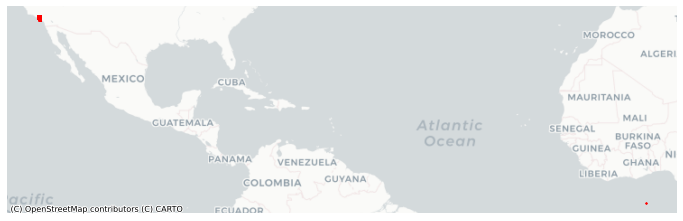

In [37]:
# Let's plot arrests

fig, ax = plt.subplots(figsize=(12,12))

arrests.plot(ax=ax,
        color='red',
        markersize=1)

#no axis
ax.axis('off')

#add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [39]:
#fix the error

arrests = arrests[arrests.lon!=0]

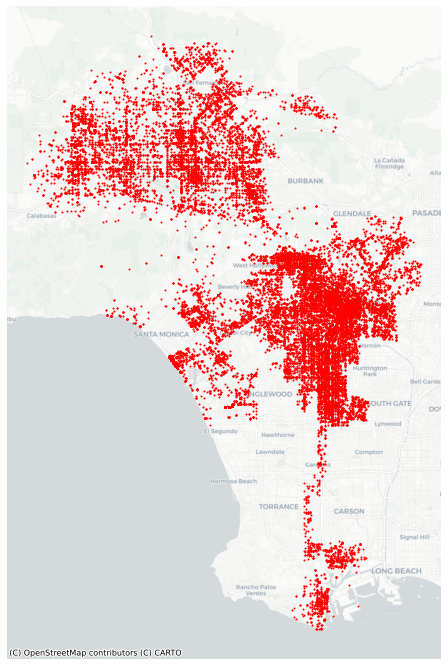

In [40]:
# Let's try again

fig, ax = plt.subplots(figsize=(12,12))

arrests.plot(ax=ax,
        color='red',
        markersize=1)

#no axis
ax.axis('off')

#add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [41]:
# to create 2 layer map lets zoom to arrest layer and get the bounding box
# get the bounding box cordimates for the arrest data using total_bound command for geometry data
minx,miny,maxx,maxy = arrests.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13209493.604053142
3989500.0479653133
-13153511.032133205
4073779.166090612


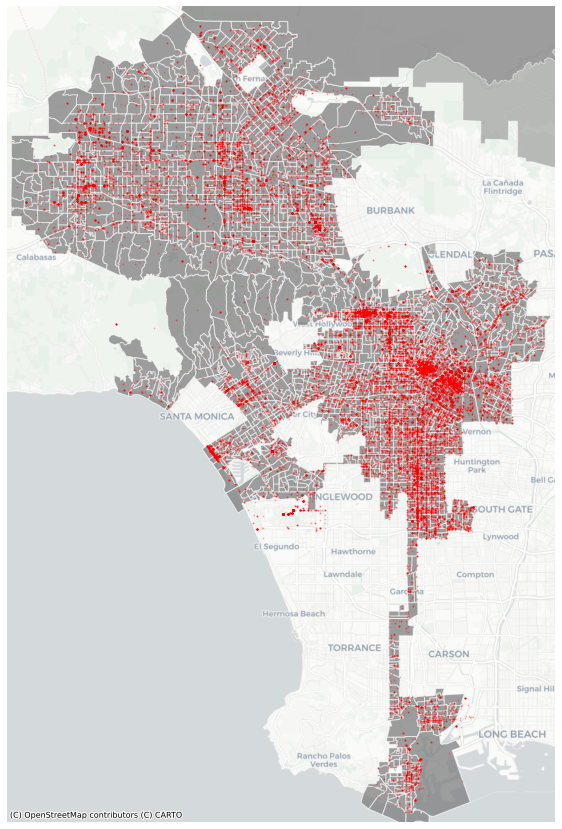

In [42]:
# let's plot again. one column one row
fig, ax = plt.subplots(1,1,figsize=(15,15))

#Block Group
gdf.plot(ax=ax,
        color='gray',
        edgecolor='white',
        alpha=0.5)

#arrests
arrests.plot(ax=ax,
        color='red',
        markersize=1,
        alpha=0.2)

#Use the bounding box cordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) #added/ subtracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

#no axis
ax.axis('off')

#add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Spatial Join

In [43]:
join = gpd.sjoin(arrests,gdf, how='left')
join.head()

,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,...,lon,location_1,bkg_date,bkg_time,bkg_location,bkg_loc_cd,geometry,index_right,FIPS,TotalPop
0,6751906,BOOKING,2024-01-31T00:00:00.000,1130,04,Hollenbeck,0423,54,M,H,...,-118.2128,"{'type': 'Point', 'coordinates': [-118.2128, 3...",2024-01-31T00:00:00.000,1446,METRO - JAIL DIVISION,4273,POINT (-13159388.701 4037398.903),2427.0,060371999001,1280.0
0,6751906,BOOKING,2024-01-31T00:00:00.000,1130,04,Hollenbeck,0423,54,M,H,...,-118.2128,"{'type': 'Point', 'coordinates': [-118.2128, 3...",2024-01-31T00:00:00.000,1446,METRO - JAIL DIVISION,4273,POINT (-13159388.701 4037398.903),541.0,14000US06037199900,2341.0
1,6752081,BOOKING,2024-01-31T00:00:00.000,2120,04,Hollenbeck,0471,17,M,H,...,-118.2257,"{'type': 'Point', 'coordinates': [-118.2257, 3...",2024-01-31T00:00:00.000,2335,METRO - JAIL DIVISION,4273,POINT (-13160824.723 4033462.341),581.0,14000US06037206050,2317.0
1,6752081,BOOKING,2024-01-31T00:00:00.000,2120,04,Hollenbeck,0471,17,M,H,...,-118.2257,"{'type': 'Point', 'coordinates': [-118.2257, 3...",2024-01-31T00:00:00.000,2335,METRO - JAIL DIVISION,4273,POINT (-13160824.723 4033462.341),2517.0,060372060501,2317.0
2,6751988,BOOKING,2024-01-31T00:00:00.000,1740,13,Newton,1351,57,M,B,...,-118.2775,"{'type': 'Point', 'coordinates': [-118.2775, 3...",2024-01-31T00:00:00.000,1907,METRO - JAIL DIVISION,4273,POINT (-13166591.072 4029809.137),3025.0,060372318004,1422.0


In [45]:
# My Bad :( not all FIPS were starting from 15000US, lets fix it again
join['FIPS'] = join['FIPS'].str.replace('14000US','')
join.tail()

,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,...,lon,location_1,bkg_date,bkg_time,bkg_location,bkg_loc_cd,geometry,index_right,FIPS,TotalPop
37979,6633814,BOOKING,2023-07-01T00:00:00.000,0800,01,Central,0147,64,M,B,...,-118.2443,"{'type': 'Point', 'coordinates': [-118.2443, 3...",2023-07-01T00:00:00.000,1013,METRO - JAIL DIVISION,4273,POINT (-13162895.265 4034886.332),586.0,06037206201,2203.0
37980,6634083,BOOKING,2023-07-01T00:00:00.000,2300,01,Central,0119,32,M,H,...,-118.2375,"{'type': 'Point', 'coordinates': [-118.2375, 3...",2023-07-02T00:00:00.000,0152,METRO - JAIL DIVISION,4273,POINT (-13162138.293 4036337.375),2533.0,060372071021,3198.0
37980,6634083,BOOKING,2023-07-01T00:00:00.000,2300,01,Central,0119,32,M,H,...,-118.2375,"{'type': 'Point', 'coordinates': [-118.2375, 3...",2023-07-02T00:00:00.000,0152,METRO - JAIL DIVISION,4273,POINT (-13162138.293 4036337.375),592.0,06037207102,3198.0
37981,6633811,BOOKING,2023-07-01T00:00:00.000,0650,15,N Hollywood,1549,30,M,B,...,-118.3789,"{'type': 'Point', 'coordinates': [-118.3789, 3...",2023-07-01T00:00:00.000,0924,VALLEY - JAIL DIV,4279,POINT (-13177878.869 4051920.873),224.0,06037125310,3598.0
37981,6633811,BOOKING,2023-07-01T00:00:00.000,0650,15,N Hollywood,1549,30,M,B,...,-118.3789,"{'type': 'Point', 'coordinates': [-118.3789, 3...",2023-07-01T00:00:00.000,0924,VALLEY - JAIL DIV,4279,POINT (-13177878.869 4051920.873),1663.0,060371253104,547.0


In [46]:
join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 75169 entries, 0 to 37981
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   rpt_id           75169 non-null  object  
 1   report_type      75169 non-null  object  
 2   arst_date        75169 non-null  object  
 3   time             75165 non-null  object  
 4   area             75169 non-null  object  
 5   area_desc        75169 non-null  object  
 6   rd               75169 non-null  object  
 7   age              75169 non-null  object  
 8   sex_cd           75169 non-null  object  
 9   descent_cd       75169 non-null  object  
 10  chrg_grp_cd      67098 non-null  object  
 11  grp_description  67090 non-null  object  
 12  arst_typ_cd      75169 non-null  object  
 13  charge           75169 non-null  object  
 14  chrg_desc        67098 non-null  object  
 15  dispo_desc       67367 non-null  object  
 16  location         75169 non-null 

In [52]:
# Now we may know how many arrests were made in each FIPS

arrests_by_gdf = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='arrests_count')

In [53]:
arrests_by_gdf.head()

,FIPS,arrests_count
0,06037208801,1395
1,060372088011,1346
2,06037207711,660
3,060372077111,660
4,06037128210,551


### Bar Plots

<AxesSubplot:xlabel='FIPS'>

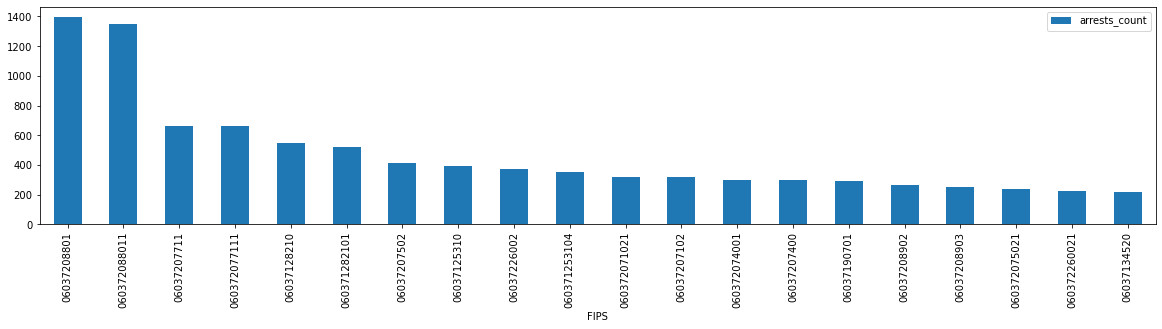

In [54]:
#make a bar chart of top 20 geographies
arrests_by_gdf[:20].plot.bar(figsize=(20,4),
                            x='FIPS',
                            y='arrests_count')

In [55]:
#Bar chart is not loking very informative as block numbers do not make sense. Lets merge counts back to the block group gdf.
# Join the summary table back to gdf
gdf = gdf.merge(arrests_by_gdf,on='FIPS')

In [56]:
gdf.head()


,FIPS,TotalPop,geometry,arrests_count
0,060371011101,1415.0,"MULTIPOLYGON (((-13168130.287 4063777.973, -13...",2
1,060371011102,1826.0,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",7
2,060371011103,773.0,"MULTIPOLYGON (((-13169185.15 4064208.314, -131...",5
3,060371011221,2754.0,"MULTIPOLYGON (((-13169467.902 4065613.937, -13...",1
4,060371012201,1307.0,"MULTIPOLYGON (((-13167528.828 4062965.287, -13...",1


In [60]:
#Before ploting the arrests_count, lets normalize our data
gdf['arrests_per_1000'] = gdf['arrests_count']/gdf['TotalPop']*1000

#sorting again
gdf.sort_values(by="arrests_per_1000").tail(20)

,FIPS,TotalPop,geometry,arrests_count,arrests_per_1000
1013,060371901011,955.0,"MULTIPOLYGON (((-13173919.902 4042790.978, -13...",135,141.361257
1313,060372074001,2091.0,"MULTIPOLYGON (((-13163883.226 4036698.552, -13...",298,142.515543
574,060371282101,3480.0,"MULTIPOLYGON (((-13185650.639 4053893.661, -13...",523,150.287356
2236,060372735023,848.0,"MULTIPOLYGON (((-13189115.569 4026857.882, -13...",131,154.481132
241,060371133032,1191.0,"MULTIPOLYGON (((-13202321.067 4062417.019, -13...",209,175.482788
1678,060372260021,1278.0,"MULTIPOLYGON (((-13164628.51 4033003.746, -131...",227,177.621283
1316,060372075021,1338.0,"MULTIPOLYGON (((-13163846.379 4035446.843, -13...",238,177.877429
1888,060372376004,724.0,"MULTIPOLYGON (((-13167410.829 4025590.204, -13...",142,196.132597
1679,060372260022,682.0,"MULTIPOLYGON (((-13163756.433 4032501.784, -13...",148,217.008798
1287,060372060511,448.0,"MULTIPOLYGON (((-13162384.42 4030801.699, -131...",106,236.607143


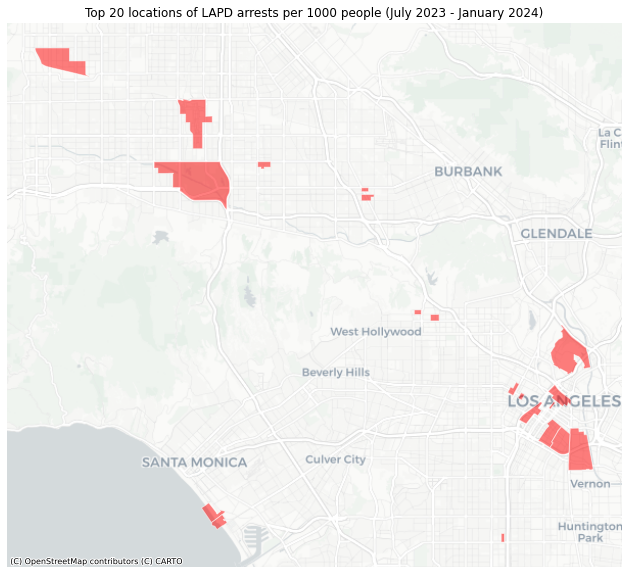

In [62]:
#Lets plot top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
gdf.sort_values(by='arrests_per_1000',ascending=False)[:20].plot(ax=ax,
                                                                color='red',
                                                                edgecolor='white',
                                                                alpha=0.5,legend=True)
#Title
ax.set_title('Top 20 locations of LAPD arrests per 1000 people (July 2023 - January 2024)')

#no axis
ax.axis('off')

#add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

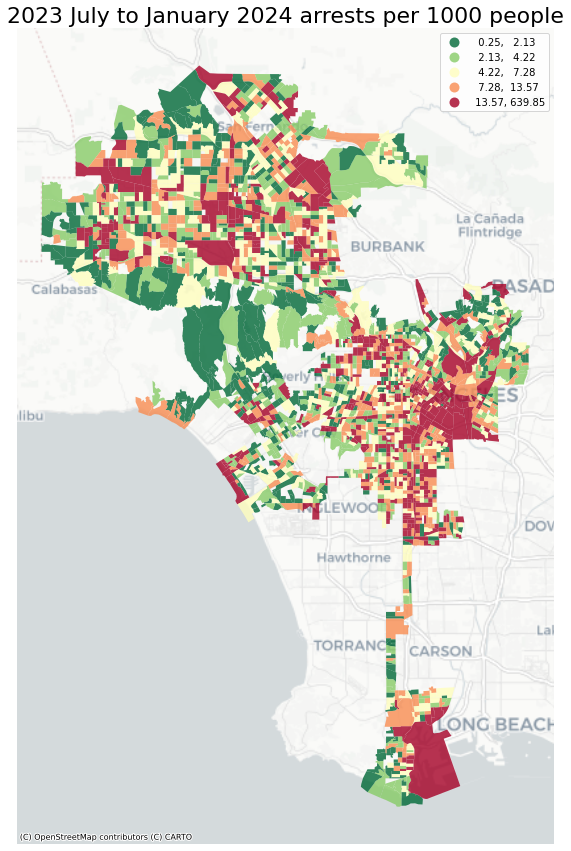

In [65]:
#Lets make a Choropleth map
fig,ax=plt.subplots(figsize=(15,15))


gdf.plot(ax=ax,
        column='arrests_per_1000',# this makes it choropleth
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',# a diverging color scheme
        scheme='quantiles') # how to break data into bins

ax.axis('off')
ax.set_title('2023 July to January 2024 arrests per 1000 people', fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Global Spatial Autocorrelation

####The goal is to find the statistical significance of these arrets. Are these arrests random? or there is a spatial correlation.
####Global Moran's I statistics is a phenomenon that can help
####Spatial weights: there are various methods but we will use KNN weight where k is the number of 'nearest neighbors'. we will use k=8

In [68]:
#calculate spatial weight
wq = lps.weights.KNN.from_dataframe(gdf,k=8)

#Row-standardization
wq.transform = 'r'

In [69]:
#now we quantify all 8 neigbours and get a single number (avg?) as its value

# create a new column for spatial lag
gdf['arrests_per_1000_lag'] = lps.weights.lag_spatial(wq, gdf['arrests_per_1000'])

In [70]:
# sample give us 10 random rows
gdf.sample(10)[['TotalPop','arrests_count','arrests_per_1000','arrests_per_1000_lag']]

,TotalPop,arrests_count,arrests_per_1000,arrests_per_1000_lag
873,1794.0,4,2.229654,2.835845
456,2463.0,1,0.406009,6.554016
1197,1901.0,21,11.046817,8.875543
2096,1534.0,2,1.303781,3.496677
310,2661.0,14,5.261180,18.164315
249,2298.0,34,14.795474,9.745931
1252,2312.0,15,6.487889,5.620327
2324,1430.0,13,9.090909,5.273246
1400,2307.0,23,9.969658,13.422708
1748,1881.0,5,2.658161,11.640298


####The Donut and the Diamond. 
####Diamond: high number arrest in the block but surrounding neighbour blocks have less number of arrests.
####Donut: small number arrest in the block but surrounding neighbour blocks have large number of arrests.

In [71]:
#to understand diamond/ donut in LA arrests data let find the difference between actual and lag (KNN)
gdf['arrest_lag_diff'] = gdf['arrests_per_1000'] - gdf['arrests_per_1000_lag']

gdf.sort_values(by='arrest_lag_diff')

,FIPS,TotalPop,geometry,arrests_count,arrests_per_1000,arrests_per_1000_lag,arrest_lag_diff
506,060371253105,781.0,"MULTIPOLYGON (((-13177345.426 4051941.997, -13...",6,7.682458,124.702237,-117.019779
1354,060372089021,1597.0,"MULTIPOLYGON (((-13166277.485 4036510.169, -13...",65,40.701315,141.843895,-101.142580
500,060371252001,1605.0,"MULTIPOLYGON (((-13178865.939 4051940.92, -131...",14,8.722741,104.578374,-95.855633
538,060371274002,1679.0,"MULTIPOLYGON (((-13189788.162 4056701.584, -13...",5,2.977963,98.188307,-95.210344
466,060371241022,990.0,"MULTIPOLYGON (((-13178498.584 4052429.881, -13...",7,7.070707,102.196261,-95.125554
...,...,...,...,...,...,...,...
2445,060379800241,137.0,"MULTIPOLYGON (((-13193418.068 4053521.172, -13...",53,386.861314,4.300823,382.560490
2442,060379800101,175.0,"MULTIPOLYGON (((-13163713.575 4039600.478, -13...",69,394.285714,6.303460,387.982254
1350,060372088011,2282.0,"MULTIPOLYGON (((-13166927.035 4036610.273, -13...",1346,589.833479,49.321538,540.511941
505,060371253104,547.0,"MULTIPOLYGON (((-13177892.45 4051941.862, -131...",350,639.853748,47.292057,592.561691


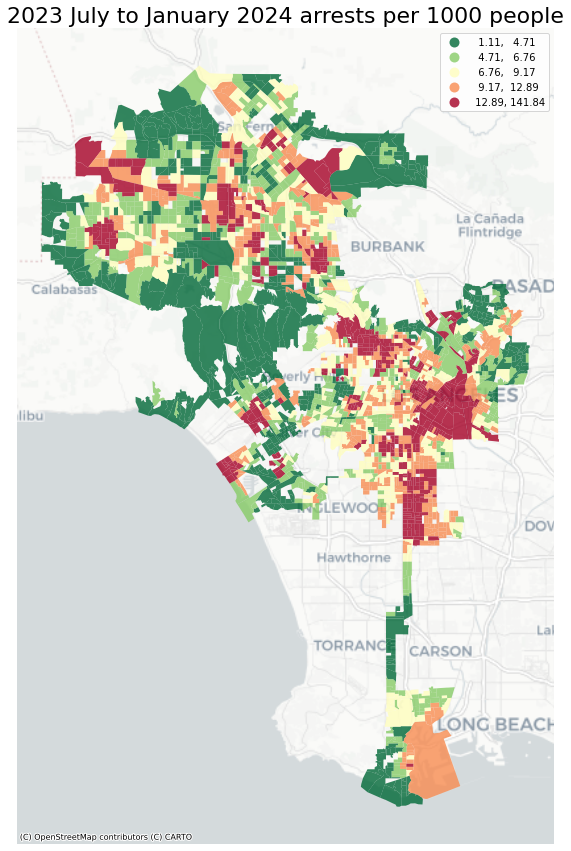

In [73]:
#Lets create a map for lag 
fig,ax=plt.subplots(1,1,figsize=(15,15))


gdf.plot(ax=ax,
         figsize=(15,15),
        column='arrests_per_1000_lag',# this makes it choropleth
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',# a diverging color scheme
        scheme='quantiles') # how to break data into bins

ax.axis('off')
ax.set_title('2023 July to January 2024 arrests per 1000 people', fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

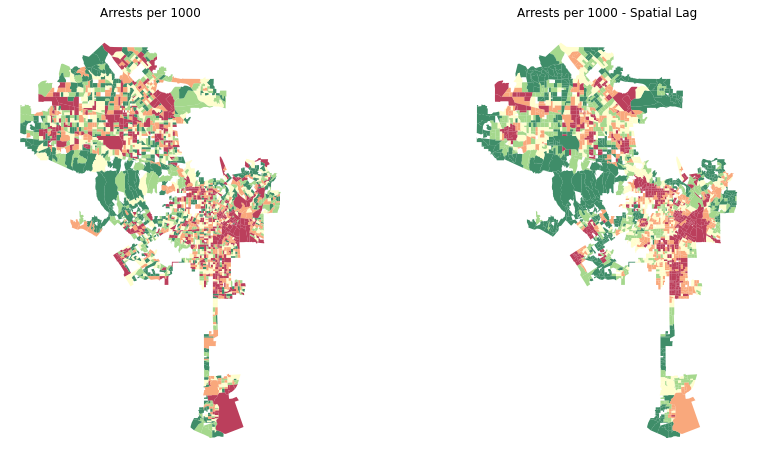

In [74]:
#Its hard to compare maps. Lets put them side by side. 
fig,ax = plt.subplots(1,2,figsize=(15,8))

#Regular count map on the left
gdf.plot(ax=ax[0], # this assigns map to the left subplot
        column='arrests_per_1000',
        cmap='RdYlGn_r',
        scheme='quantiles',
        k=5,
        edgecolor='white',
        linewidth=0,
        alpha=0.75)

ax[0].axis("off")
ax[0].set_title("Arrests per 1000")

#Spatial lag map on the right
gdf.plot(ax=ax[1], # this assigns map to the right subplot
        column='arrests_per_1000_lag',
        cmap='RdYlGn_r',
        scheme='quantiles',
        k=5,
        edgecolor='white',
        linewidth=0,
        alpha=0.75)

ax[1].axis("off")
ax[1].set_title("Arrests per 1000 - Spatial Lag")

plt.show()


In [75]:
# all this pain is to get Moran's I number. 

y = gdf.arrests_per_1000
moran = Moran(y, wq)
moran.I

0.10866480065909427

The moran's I value is nothing more than the calculated slope of the scatterplot of our "arrests per 1000" and "arrests per 1000 spatial lag" columns. It does indicate whether or not you have a positive or negative autocorrelation. Values will range from positive one, to negative one.

- Positive spatial autocorrelation: high values are close to high values, and/or low values are close to low values
- Negative spatial autocorrelation (less common): similar values are far from each other; high values are next to low values, low values are next to high values

## Next step is to dive further in the analysis and conduct local spatial autocorrelation (LISA?)

In [78]:
# import splot
# from splot.esda import moral_scatterplot, plot_moral, lisa_cluster, plot_moran_simulation

In [1]:
# fig, ax = moran_scatterplot(moran, aspect_equal=True)
# plt.show()